## Text Mining em documentos de Defesa Norte Americanos

##### Objetivo:
* Ver a quantidade de vezes que palavras relacionadas com cyber security aparecem aparecem conforme passam os anos.

##### Procedimento:
1. Ler cada documento deixando claro a que ano se refere
2. Remover pontuações e stopwords (lembrando de adicionar palavras como us, united, states)
3. Realizar a contagem de palavras
4. Plotar a evolução histórica dessa contagem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from PyPDF2 import PdfFileReader
from bs4 import BeautifulSoup
import re
import string
import glob
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

%matplotlib inline

Criando função que lerá documentos

#### Em primeiro momento, será feita uma análise geral levando em conta todos os documentos de uma só vez. Após isso, será analisado cada documento separadamente

In [2]:
def ler_(arquivo): #Essa versão é a que está valendo
    pdf = open(arquivo, "rb")
    reader = PdfFileReader(pdf)
    tamanho = reader.numPages
    
    pages = []
    
    for i in range(tamanho):
        pages.append(reader.getPage(i).extractText())
        
    text = " ".join(pages)
    
    return text

In [3]:
textos = os.listdir('textos')

In [4]:
textos[0][:4]

'2006'

Lendo documentos e armazenando por ano num DataFrame

In [5]:
ano = []
text = []
for texto in textos:
    ano.append(texto[:4])
    text.append(ler_('textos/'+texto))

In [6]:
df = pd.DataFrame(text, columns=['text'], index=ano)

In [7]:
df.head()

,text
2006,Annual Threat Assessment of the Director...
2007,\n Annual Threat Assessment \nof the \nDirec...
2008,Annual Threat Assessment of the Intelli...
2009,Annual Threat Assessment of the Intelli...
2010,Annual Threat Assessment of the US Intel...


A arquivo do ano de 2011 é um pdf scaneado!

In [8]:
nltk.download('stopwords')
stop = stopwords.words('english')
#punctuation = list(string.punctuation)
#stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Adicionando algumas palavras que se percebeu ser comum nos arquivos e que não somam muito no objetivo
stop.append('us')
stop.append('united')
stop.append('states')
stop.append('also')

#### Tirando caracteres especiais

In [10]:
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_br = lambda x: re.sub(r""" br """, ' ', x.lower())
remove_n = lambda x: re.sub(r""" [\r\n]+ """, ' ', x.lower())
line = lambda x: x.strip()
linen =  lambda x: re.sub("\n","",x)


df['text_b'] = df.text.map(alphanumeric).map(punc_lower).map(remove_br).map(remove_n).map(line).map(linen)
df['text_b'] = df['text_b'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))



In [11]:
df.head()

,text,text_b
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...


Criando função que vai contabilizar as palavras no conjunto de arquivos

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, g):
    vec = CountVectorizer(ngram_range=(g, g), stop_words=stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [13]:
most_common_uni = get_top_text_ngrams(df.text_b,1)
most_common_uni = dict(most_common_uni)

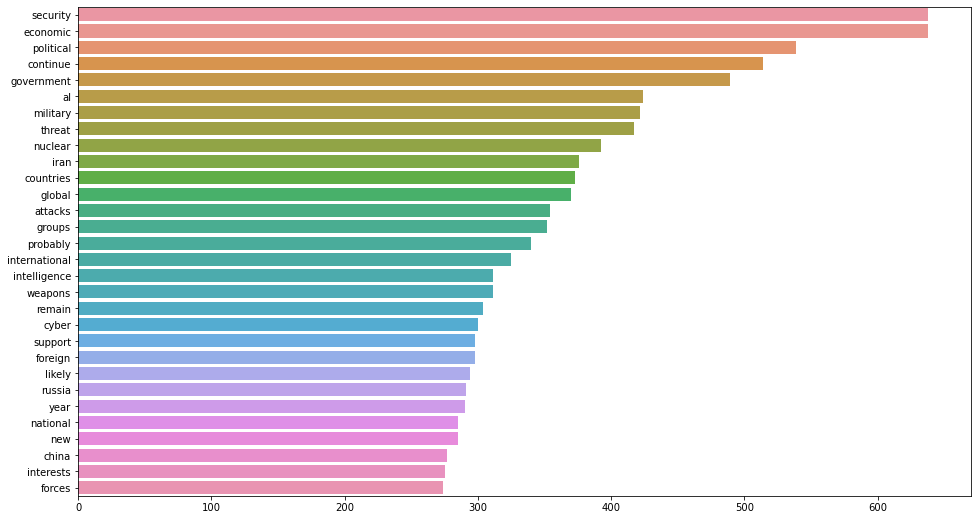

In [14]:
plt.figure(figsize = (16,9))
sns.barplot(x=list(most_common_uni.values())[:30],y=list(most_common_uni.keys())[:30])
plt.show()

In [15]:
most_common_uni

{'security': 638,
 'economic': 638,
 'political': 539,
 'continue': 514,
 'government': 489,
 'al': 424,
 'military': 422,
 'threat': 417,
 'nuclear': 392,
 'iran': 376,
 'countries': 373,
 'global': 370,
 'attacks': 354,
 'groups': 352,
 'probably': 340,
 'international': 325,
 'intelligence': 311,
 'weapons': 311,
 'remain': 304,
 'cyber': 300,
 'support': 298,
 'foreign': 298,
 'likely': 294,
 'russia': 291,
 'year': 290,
 'national': 285,
 'new': 285,
 'china': 277,
 'interests': 275,
 'forces': 274,
 'north': 269,
 'capabilities': 259,
 'efforts': 256,
 'terrorist': 247,
 'regional': 246,
 'iraq': 245,
 'state': 244,
 'including': 244,
 'region': 244,
 'oil': 243,
 'influence': 238,
 'assess': 234,
 'threats': 231,
 'use': 224,
 'leaders': 222,
 'since': 219,
 'could': 219,
 'syria': 217,
 'operations': 216,
 'however': 211,
 'growth': 206,
 'years': 204,
 'power': 202,
 'qaida': 201,
 'violence': 201,
 'many': 196,
 'president': 195,
 'conflict': 190,
 'record': 190,
 'statement'

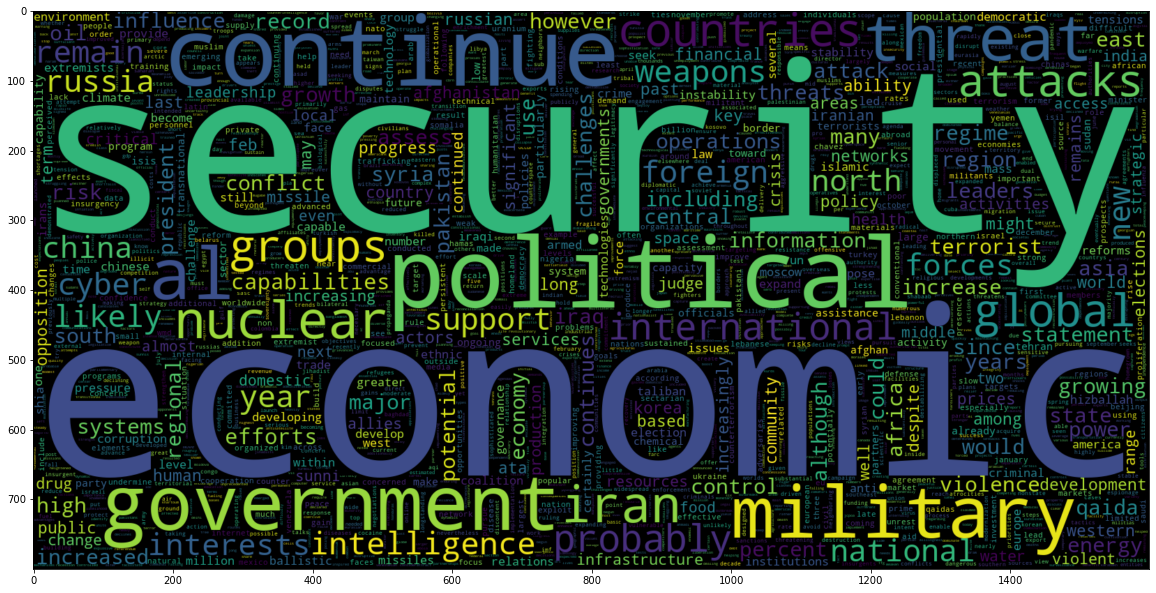

In [16]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).fit_words(most_common_uni)
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('worldAll1', dpi=600)
plt.show()

In [16]:
tudo = pd.DataFrame(data = most_common_uni.values(), index = most_common_uni.keys(), columns = ['quantidade'])

#### Quantidade total de palavras

In [17]:
tudo.quantidade.sum()

104434

In [18]:
tudo.quantidade 

security              638
economic              638
political             539
continue              514
government            489
                     ... 
ivan                    1
fraying                 1
miguel                  1
institutionalizing      1
canel                   1
Name: quantidade, Length: 10581, dtype: int64

In [19]:
(tudo.quantidade / tudo.quantidade.sum())*100

security              0.610912
economic              0.610912
political             0.516115
continue              0.492177
government            0.468238
                        ...   
ivan                  0.000958
fraying               0.000958
miguel                0.000958
institutionalizing    0.000958
canel                 0.000958
Name: quantidade, Length: 10581, dtype: float64

In [20]:
most_common_bi = get_top_text_ngrams(df.text_b,2)
most_common_bi = dict(most_common_bi)
most_common_bi

{'al qaida': 201,
 'statement record': 158,
 'north korea': 136,
 'ata feb': 135,
 'feb statement': 135,
 'nuclear weapons': 127,
 'national security': 95,
 'middle east': 94,
 'almost certainly': 89,
 'economic growth': 86,
 'intelligence community': 84,
 'climate change': 68,
 'ballistic missiles': 62,
 'long term': 61,
 'foreign policy': 59,
 'last year': 58,
 'political economic': 58,
 'terrorist groups': 57,
 'security forces': 53,
 'organized crime': 52,
 'prime minister': 52,
 'al qaidas': 51,
 'latin america': 51,
 'oil prices': 50,
 'probably continue': 49,
 'past year': 48,
 'south asia': 45,
 'international community': 44,
 'next year': 44,
 'sasc ata': 44,
 'transnational organized': 43,
 'likely continue': 42,
 'east asia': 39,
 'iraq syria': 38,
 'private sector': 38,
 'russia china': 38,
 'rule law': 37,
 'law enforcement': 36,
 'ballistic missile': 35,
 'chemical weapons': 33,
 'terrorist attacks': 33,
 'north africa': 33,
 'central asia': 32,
 'critical infrastructure'

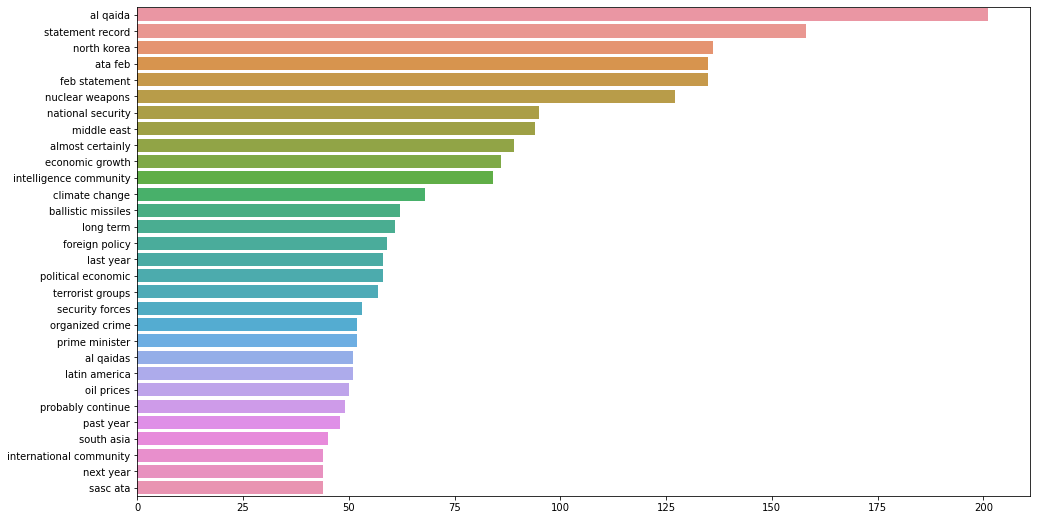

In [21]:
plt.figure(figsize = (16,9))
sns.barplot(x=list(most_common_bi.values())[:30],y=list(most_common_bi.keys())[:30])
plt.show()

In [22]:
most_common_bi

{'al qaida': 201,
 'statement record': 158,
 'north korea': 136,
 'ata feb': 135,
 'feb statement': 135,
 'nuclear weapons': 127,
 'national security': 95,
 'middle east': 94,
 'almost certainly': 89,
 'economic growth': 86,
 'intelligence community': 84,
 'climate change': 68,
 'ballistic missiles': 62,
 'long term': 61,
 'foreign policy': 59,
 'last year': 58,
 'political economic': 58,
 'terrorist groups': 57,
 'security forces': 53,
 'organized crime': 52,
 'prime minister': 52,
 'al qaidas': 51,
 'latin america': 51,
 'oil prices': 50,
 'probably continue': 49,
 'past year': 48,
 'south asia': 45,
 'international community': 44,
 'next year': 44,
 'sasc ata': 44,
 'transnational organized': 43,
 'likely continue': 42,
 'east asia': 39,
 'iraq syria': 38,
 'private sector': 38,
 'russia china': 38,
 'rule law': 37,
 'law enforcement': 36,
 'ballistic missile': 35,
 'chemical weapons': 33,
 'terrorist attacks': 33,
 'north africa': 33,
 'central asia': 32,
 'critical infrastructure'

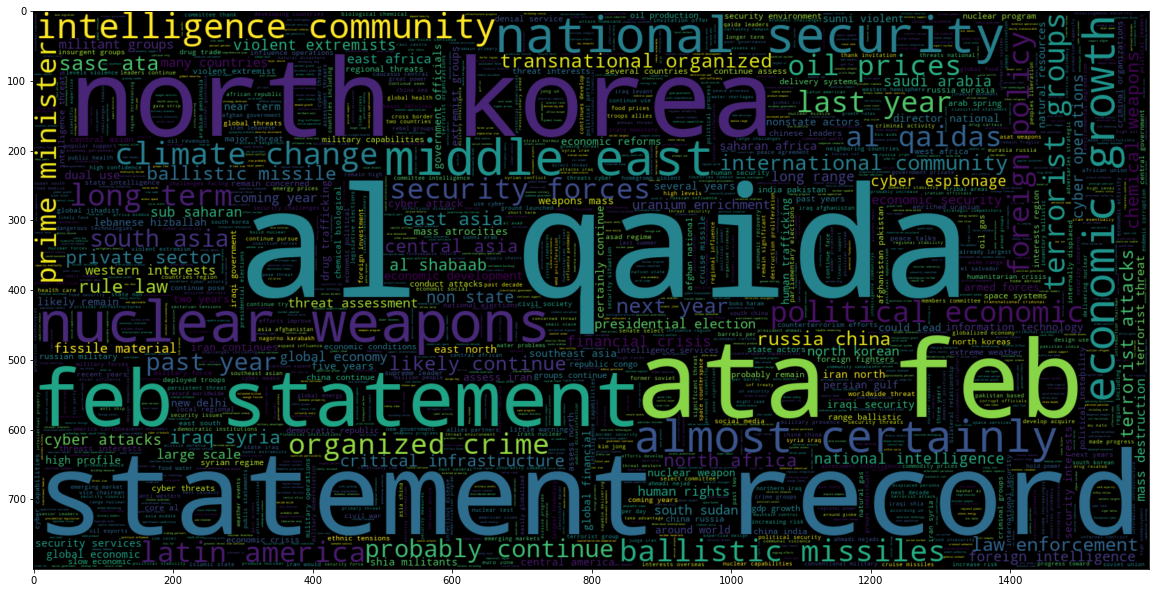

In [23]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).fit_words(most_common_bi)
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('worldAll2', dpi=600)
plt.show()

In [24]:
#Para fazer tokenização

df['token'] = df.text_b.map(word_tokenize)

In [25]:
df.head()

,text,text_b,token
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte..."


In [26]:
stop_lambda = lambda x: [y for y in x if y not in stop]
#aplica a função na coluna dos tokens
df['tokens_stop'] = df.token.apply(stop_lambda)
df.head()

,text,text_b,token,tokens_stop
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com..."


In [27]:
# partes de speech tagging
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
pos_lambda = lambda x: nltk.pos_tag(x)
df['tokens_pos'] = (df.tokens_stop.apply(pos_lambda))
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,text,text_b,token,tokens_stop,tokens_pos
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),..."


In [28]:
# Realizar lematização, que é uma forma mais inteligente de derivação e leva em consideração o contexto
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('all')

# Convert the naming scheme to one that is recognized by WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()
lemmatizer_fun = lambda x: lemmatizer.lemmatize(*x)
df['tokens_lemma'] = df.tokens_pos\
                        .apply(lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x])\
                        .apply(lambda x: [lemmatizer_fun(y) for y in x])



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown

In [29]:
df.head().T

,2006,2007,2008,2009,2010
text,Annual Threat Assessment of the Director...,\n Annual Threat Assessment \nof the \nDirec...,Annual Threat Assessment of the Intelli...,Annual Threat Assessment of the Intelli...,Annual Threat Assessment of the US Intel...
text_b,annual threat assessment of the director of na...,annual threat assessment of the director of na...,annual threat assessment of the intelligence...,annual threat assessment of the intelligence...,annual threat assessment of the us intellige...
token,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, of, the, director...","[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, of, the, us, inte..."
tokens_stop,"[annual, threat, assessment, director, nationa...","[annual, threat, assessment, director, nationa...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com..."
tokens_pos,"[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
tokens_lemma,"[annual, threat, assessment, director, nationa...","[annual, threat, assessment, director, nationa...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com..."


### Adiciona Bi-Grams ede todas as linhas

In [30]:
di = {}

for x in df.index:
    g = []
    for gram in ngrams(df['tokens_lemma'][x],2): 
        g.append(' '.join(gram))
    di[x] = g

In [31]:
df['bi_gram'] = di.values()

In [32]:
df.head()

,text,text_b,token,tokens_stop,tokens_pos,tokens_lemma,bi_gram
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ..."


### Adiciona Tri-Grams ede todas as linhas

In [33]:
di = {}

for x in df.index:
    g = []
    for gram in ngrams(df['tokens_lemma'][x],3): 
        g.append(' '.join(gram))
    di[x] = g

In [34]:
df['tri_gram'] = di.values()

In [35]:
df.head()

,text,text_b,token,tokens_stop,tokens_pos,tokens_lemma,bi_gram,tri_gram
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment d..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment d..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment i..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment i..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment i..."


Aqui termina os tratamentos anuais.
<br>
------------------------------------
   #### A partir daqui começa a análise de cada ano separadamente

Análises de 1 palavra

In [36]:
def analise_ano_x(df, ano, gerar_wordcloud = 0):
    '''
    df -> dataframe onde está o texto tratado
    ano -> STRING com o ano que se deseja analisar. No momento está disponível de 2006 a 2019, com exceção de 2011
    '''
    # Converte a lista em um dicionário com contagem de valores
    word_counts = Counter(df['tokens_stop'][ano])
    b = word_counts
    a = word_counts
    

    # Inverter a chave / valores no dicionário para classificarReverter a chave / valores no dicionário para classificar
    word_counts = list(zip(word_counts.values(), word_counts.keys()))

    # Classifique a lista por contagem
    word_counts = sorted(word_counts, reverse=True)

    # Imprime as 20 palavras mais comuns
    print(word_counts[:20])
    
    
    #Fazendo relatório
    b = list(zip(b.keys(), b.values()))
    b = sorted(b, reverse=True, key = lambda x: x[1])
    relatorio = pd.DataFrame(data = dict(b).values(), index = dict(b).keys(), columns = ['quantidade'])
    total_de_palavras = relatorio.quantidade.sum()
    porcentagem = relatorio.quantidade / relatorio.quantidade.sum()
    print(relatorio.head())
    print('---------')
    print(porcentagem.head())
    result = pd.concat([relatorio, porcentagem.to_frame('porcentagem')], axis=1, sort=False)
    
    if gerar_wordcloud == 1:
        nome = 'wordcloud'+ano+'.png'    
        wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(a) # o 'a' veio de um counter
        plt.figure(figsize=(16,13))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(nome, dpi=600)
        plt.show()
    
    return result

In [37]:
d2006 = analise_ano_x(df, '2006')
d2007 = analise_ano_x(df, '2007')
d2008 = analise_ano_x(df, '2008')
d2009 = analise_ano_x(df, '2009')
d2010 = analise_ano_x(df, '2010')
#d2011 = analise_ano_x(df, '2011')
d2012 = analise_ano_x(df, '2012')
d2013 = analise_ano_x(df, '2013')
d2014 = analise_ano_x(df, '2014')
d2015 = analise_ano_x(df, '2015')
d2016 = analise_ano_x(df, '2016')
d2017 = analise_ano_x(df, '2017')
d2018 = analise_ano_x(df, '2018')
d2019 = analise_ano_x(df, '2019')

[(38, 'political'), (31, 'intelligence'), (31, 'al'), (30, 'economic'), (24, 'iraq'), (24, 'global'), (23, 'weapons'), (23, 'government'), (22, 'threat'), (22, 'groups'), (21, 'security'), (21, 'iran'), (20, 'new'), (18, 'world'), (18, 'qaida'), (18, 'nuclear'), (18, 'interests'), (17, 'sunni'), (16, 'national'), (16, 'forces')]
              quantidade
political             38
intelligence          31
al                    31
economic              30
global                24
---------
political       0.007652
intelligence    0.006242
al              0.006242
economic        0.006041
global          0.004833
Name: quantidade, dtype: float64
[(24, 'region'), (22, 'security'), (20, 'political'), (20, 'al'), (19, 'national'), (19, 'iraq'), (19, 'government'), (17, 'intelligence'), (16, 'year'), (15, 'power'), (15, 'nuclear'), (15, 'energy'), (15, 'countries'), (14, 'terrorist'), (14, 'major'), (14, 'last'), (13, 'pakistan'), (13, 'economic'), (13, 'continue'), (12, 'threat')]
           q

Será feito toda a análise para 1 palavra e depois replicado para bigramas e trigramas

In [38]:
d2016

,quantidade,porcentagem
continue,60,0.007719
probably,54,0.006947
security,48,0.006175
threat,41,0.005275
political,38,0.004889
...,...,...
organizers,1,0.000129
models,1,0.000129
cooperating,1,0.000129
hosted,1,0.000129


In [39]:
d2016.filter(like='cyber', axis=0)

,quantidade,porcentagem
cyber,23,0.002959
cyberattacks,3,0.000386
cyberattack,2,0.000257
cybersecurity,1,0.000129
cyberspace,1,0.000129


In [40]:
print('Quantidade:',d2016.filter(like='cyber', axis=0).quantidade.sum())
print('Porcentagem:',d2016.filter(like='cyber', axis=0).porcentagem.sum())

Quantidade: 30
Porcentagem: 0.003859513701273639


In [43]:
#Objetivo aqui, talvez possa ser criar esse dicionário para todos os anos onde a análise foi feita. Após isso, criar uma plotagem em formato de linha do tempo mostrando a evolução
#das variáveis
numeros = {}
ano = []
qtd = []
porc = []
#2006
ano.append(2006)
qtd.append(d2006.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2006.filter(like='cyber', axis=0).porcentagem.sum())

#2007
ano.append(2007)
qtd.append(d2007.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2007.filter(like='cyber', axis=0).porcentagem.sum())

#2008
ano.append(2008)
qtd.append(d2008.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2008.filter(like='cyber', axis=0).porcentagem.sum())

#2009
ano.append(2009)
qtd.append(d2009.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2009.filter(like='cyber', axis=0).porcentagem.sum())

#2010
ano.append(2010)
qtd.append(d2010.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2010.filter(like='cyber', axis=0).porcentagem.sum())

#2012
ano.append(2012)
qtd.append(d2012.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2012.filter(like='cyber', axis=0).porcentagem.sum())

#2013
ano.append(2013)
qtd.append(d2013.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2013.filter(like='cyber', axis=0).porcentagem.sum())

#2014
ano.append(2014)
qtd.append(d2014.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2014.filter(like='cyber', axis=0).porcentagem.sum())

#2015
ano.append(2015)
qtd.append(d2015.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2015.filter(like='cyber', axis=0).porcentagem.sum())

#2016
ano.append(2016)
qtd.append(d2016.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2016.filter(like='cyber', axis=0).porcentagem.sum())

#2017
ano.append(2017)
qtd.append(d2017.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2017.filter(like='cyber', axis=0).porcentagem.sum())

#2018
ano.append(2018)
qtd.append(d2018.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2018.filter(like='cyber', axis=0).porcentagem.sum())

#2019
ano.append(2019)
qtd.append(d2019.filter(like='cyber', axis=0).quantidade.sum())
porc.append(d2019.filter(like='cyber', axis=0).porcentagem.sum())

In [45]:
numeros = {
    'ano': ano,
    'quantidade': qtd,
    'porcentagem': porc
}

In [46]:
numeros

{'ano': [2006,
  2007,
  2008,
  2009,
  2010,
  2012,
  2013,
  2014,
  2015,
  2016,
  2017,
  2018,
  2019],
 'quantidade': [0, 0, 14, 20, 35, 13, 33, 21, 43, 30, 52, 39, 44],
 'porcentagem': [0.0,
  0.0,
  0.0014911066141229097,
  0.0014487504527345165,
  0.0026499091459721382,
  0.001767985856113151,
  0.0034876347495244138,
  0.00267379679144385,
  0.00695905486324648,
  0.003859513701273639,
  0.007101884730947829,
  0.00676261487775273,
  0.005735140771637122]}

In [47]:
resultados = pd.DataFrame(numeros)

In [48]:
resultados

,ano,quantidade,porcentagem
0,2006,0,0.000000
1,2007,0,0.000000
2,2008,14,0.001491
3,2009,20,0.001449
4,2010,35,0.002650
5,2012,13,0.001768
6,2013,33,0.003488
7,2014,21,0.002674
8,2015,43,0.006959
9,2016,30,0.003860


In [51]:
sns.set_palette("Dark2_r")
sns.set_style("darkgrid")

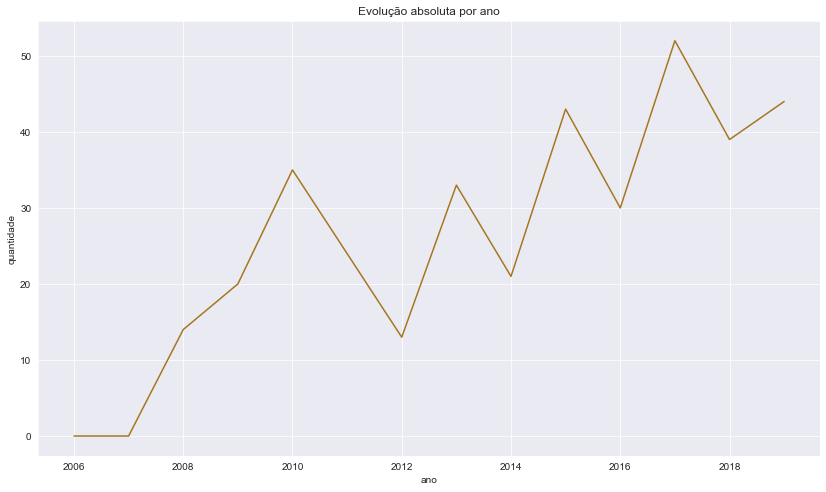

In [62]:
plt.figure(figsize=(14,8))
sns.lineplot(data=resultados, x="ano", y="quantidade")
plt.title('Evolução absoluta por ano')
plt.savefig('evolucao_absoluta_por_ano_linha.png')
plt.show()

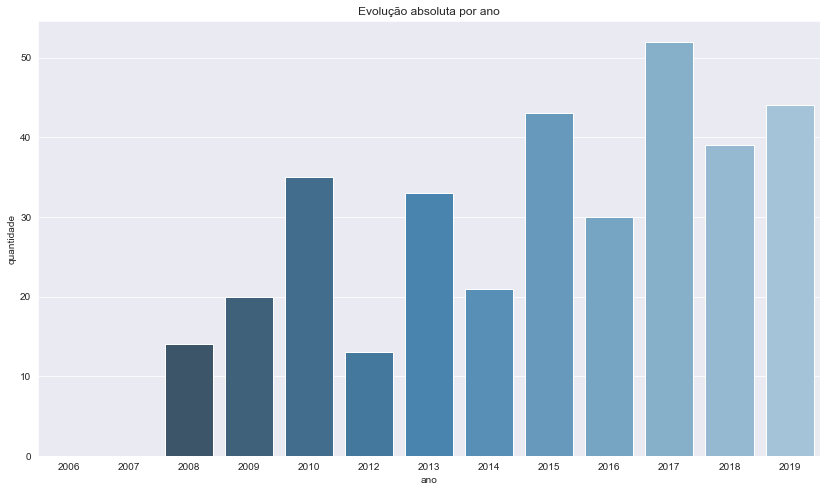

In [63]:
plt.figure(figsize=(14,8))
ax = sns.barplot(data=resultados, x="ano", y="quantidade",
                 palette="Blues_d")
plt.title('Evolução absoluta por ano')
plt.savefig('evolucao_absoluta_por_ano_barra.png')
plt.show()

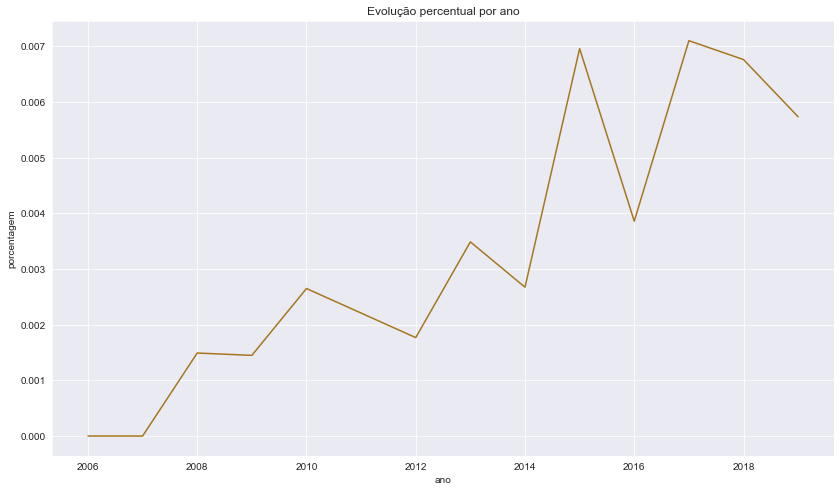

In [64]:
plt.figure(figsize=(14,8))
sns.lineplot(data=resultados, x="ano", y="porcentagem")
plt.title('Evolução percentual por ano')
plt.savefig('evolucao_percentual_por_ano_linha.png')
plt.show()

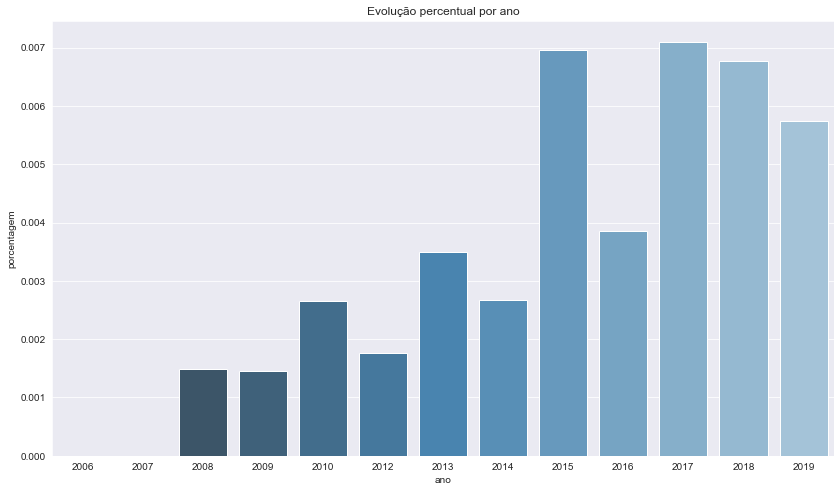

In [65]:
plt.figure(figsize=(14,8))
ax = sns.barplot(data=resultados, x="ano", y="porcentagem",
                 palette="Blues_d")
plt.title('Evolução percentual por ano')
plt.savefig('evolucao_percentual_por_ano_barra.png')
plt.show()

Ta ok. Fazer isso por ano e uma linha do tempo

# ATÉ AQUI

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text_b,20,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

In [28]:
most_common_uni

{'economic': 623,
 'security': 618,
 'political': 528,
 'continue': 507,
 'government': 468,
 'al': 447,
 'also': 415,
 'threat': 414,
 'military': 407,
 'iran': 385,
 'nuclear': 385,
 'countries': 365,
 'global': 361,
 'groups': 346,
 'attacks': 343,
 'probably': 337,
 'weapons': 304,
 'intelligence': 302,
 'remain': 299,
 'international': 299}

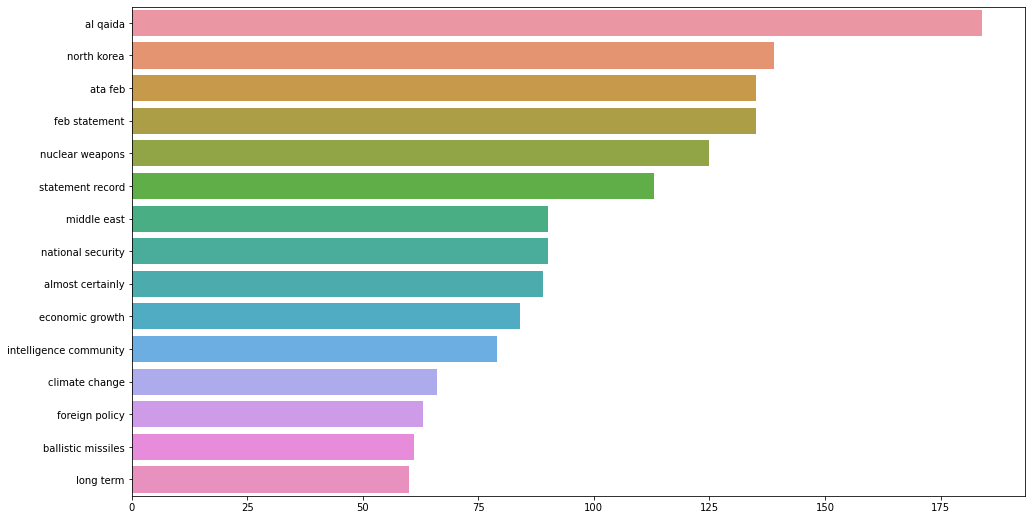

In [22]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text_b,15,2)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

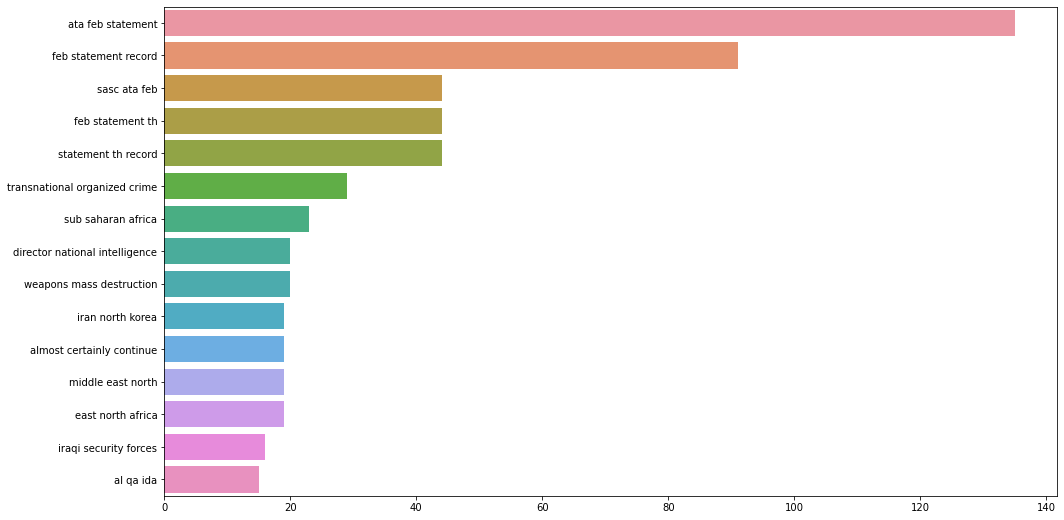

In [23]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text_b,15,3)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

In [33]:
z = get_top_text_ngrams(a.pagina,25,3)
z

[('adversaries strategic competitors', 11),
 ('united states allies', 9),
 ('online influence operations', 6),
 ('influence operations election', 4),
 ('operations election interference', 4),
 ('cyber espionage attack', 4),
 ('threats us national', 3),
 ('us national security', 3),
 ('weapons mass destruction', 3),
 ('global economic growth', 3),
 ('espionage attack influence', 3),
 ('election interference section', 3),
 ('localized temporary disruptive', 3),
 ('target us allied', 3),
 ('us adversaries strategic', 3),
 ('past two years', 3),
 ('russian president vladimir', 3),
 ('president vladimir putin', 3),
 ('including united states', 3),
 ('violent ethno supremacist', 3),
 ('south china sea', 3),
 ('kim jong un', 3),
 ('saudi arabia uae', 3),
 ('mass destruction proliferation', 2),
 ('regional threats china', 2)]

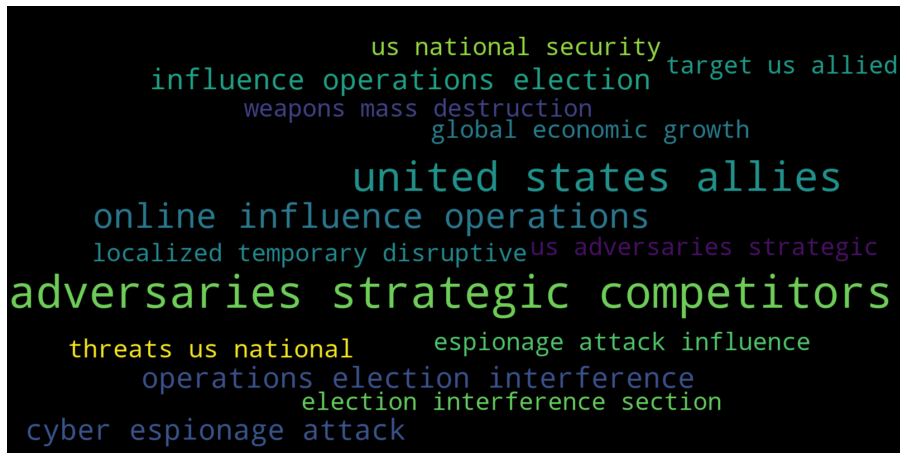

In [34]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(most_common_uni) # o 'a' veio de um counter
#wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(text)
plt.figure(figsize=(16,13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud.png', dpi=600)
plt.show()

In [8]:
#Para fazer tokenização
from nltk.tokenize import word_tokenize
a['token'] = a.pagina.map(word_tokenize)

In [9]:
a = pd.DataFrame(ab, columns = ['pagina'])

In [10]:
a

,pagina
0,january senate select committee on int...
1,statement for the record worldwide threa...
2,contents introduction ...
3,foreword threats to us national security w...
4,global t hre ats cyber our adversaries a...
5,russian intelligence and security services...
6,the growing availability and use of publicl...
7,weapons of mass destruction an d prolifera...
8,promised not to make test use or proli...
9,iran we continue to assess that iran is no...


In [11]:
a['token'] = a.pagina.map(word_tokenize)

In [12]:
a.head()

,pagina,token
0,january senate select committee on int...,"[january, senate, select, committee, on, intel..."
1,statement for the record worldwide threa...,"[statement, for, the, record, worldwide, threa..."
2,contents introduction ...,"[contents, introduction, contents, foreword, g..."
3,foreword threats to us national security w...,"[foreword, threats, to, us, national, security..."
4,global t hre ats cyber our adversaries a...,"[global, t, hre, ats, cyber, our, adversaries,..."


In [13]:
# Isso cria uma lista enorme combinando todos os valores de tokens
word_list = sum(a.token.tolist(), [])

word_list[:10]

['january',
 'senate',
 'select',
 'committee',
 'on',
 'intelligence',
 'statement',
 'for',
 'the',
 'record']

In [15]:
# Estas são as etapas para encontrar as palavras mais comuns

from collections import Counter

# Converte a lista em um dicionário com contagem de valores
word_counts = Counter(word_list)

# Inverter a chave / valores no dicionário para classificarReverter a chave / valores no dicionário para classificar
word_counts = list(zip(word_counts.values(), word_counts.keys()))

# Classifique a lista por contagem
word_counts = sorted(word_counts, reverse=True)

# Imprime as 10 palavras mais comuns
word_counts[:10]

[(710, 'and'),
 (537, 'the'),
 (494, 'to'),
 (310, 'in'),
 (289, 'of'),
 (152, 'a'),
 (131, 'will'),
 (116, 'us'),
 (102, 'as'),
 (99, 'that')]

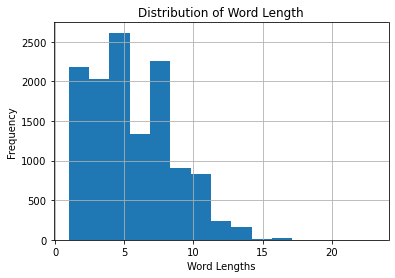

In [16]:
# A distribuição dos comprimentos das palavras
word_lengths = pd.Series([len(x) for x in word_list])

ax = word_lengths.hist(bins=15)
ax.set(xlabel='Word Lengths', ylabel='Frequency', title='Distribution of Word Length');

In [17]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#Para aplicar essa limpeza ao corpus
clean_words = [word for word in word_list if not (word in stop_words_en)]

In [19]:
clean_words

['january',
 'senate',
 'select',
 'committee',
 'intelligence',
 'statement',
 'record',
 'worldwide',
 'threat',
 'assessment',
 'us',
 'intelligence',
 'community',
 'january',
 'introduction',
 'chairman',
 'burr',
 'vice',
 'chairman',
 'warner',
 'members',
 'committee',
 'thank',
 'invitation',
 'assessment',
 'threats',
 'us',
 'national',
 'security',
 'en',
 'men',
 'privileged',
 'honored',
 'lead',
 'intelligence',
 'community',
 'committed',
 'every',
 'day',
 'providing',
 'nuanced',
 'independent',
 'unvarnished',
 'intelligence',
 'policymakers',
 'warfighters',
 'domestic',
 'law',
 'enforcement',
 'personnel',
 'need',
 'protect',
 'american',
 'lives',
 'order',
 'topics',
 'presented',
 'statement',
 'necessarily',
 'indicate',
 'relative',
 'importance',
 'magnitude',
 'threat',
 'view',
 'intelligence',
 'community',
 'informa',
 'tion',
 'available',
 'jan',
 'uary',
 'used',
 'preparation',
 'assessment',
 'attention',
 'product',
 'contains',
 'us',
 'persons',

In [20]:
#Cria a função para retirar as stopwords
stop_lambda = lambda x: [y for y in x if y not in stop_words_en]
#aplica a função na coluna dos tokens
a['tokens_stop'] = a.token.apply(stop_lambda)
a.head()

,pagina,token,tokens_stop
0,january senate select committee on int...,"[january, senate, select, committee, on, intel...","[january, senate, select, committee, intellige..."
1,statement for the record worldwide threa...,"[statement, for, the, record, worldwide, threa...","[statement, record, worldwide, threat, assessm..."
2,contents introduction ...,"[contents, introduction, contents, foreword, g...","[contents, introduction, contents, foreword, g..."
3,foreword threats to us national security w...,"[foreword, threats, to, us, national, security...","[foreword, threats, us, national, security, ex..."
4,global t hre ats cyber our adversaries a...,"[global, t, hre, ats, cyber, our, adversaries,...","[global, hre, ats, cyber, adversaries, strateg..."


In [21]:
word_list_clean = sum(a.tokens_stop.tolist(), [])

word_list_clean[:10]

['january',
 'senate',
 'select',
 'committee',
 'intelligence',
 'statement',
 'record',
 'worldwide',
 'threat',
 'assessment']

In [22]:
# Converte a lista em um dicionário com contagem de valores
word_counts_clean = Counter(word_list_clean)
b = word_counts_clean

# Inverta a chave / valores no dicionário para classificar
word_counts_clean = list(zip(word_counts_clean.values(), word_counts_clean.keys()))

# Classifique a lista por contagem
word_counts_clean = sorted(word_counts_clean, reverse=True)

# Imprime as 10 palavras mais comuns
word_counts_clean[:10]

[(116, 'us'),
 (59, 'states'),
 (57, 'china'),
 (55, 'military'),
 (52, 'economic'),
 (49, 'united'),
 (48, 'continue'),
 (47, 'russia'),
 (45, 'influence'),
 (43, 'security')]

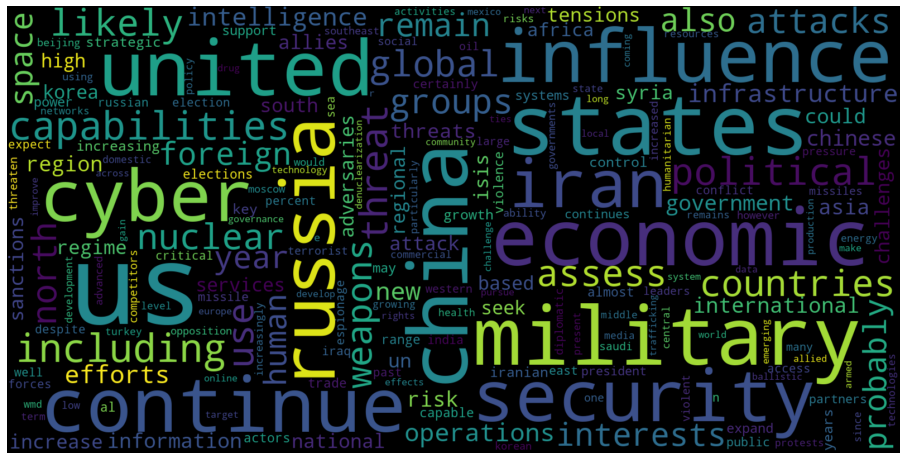

In [40]:
from wordcloud import WordCloud

text = word_list_clean
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(b) # o 'a' veio de um counter
#wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(text)
plt.figure(figsize=(16,13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png', dpi=600)
plt.show()

In [38]:
plt.savefig(wordcloud, 'wordcloud.png',dpi=600)

TypeError: savefig() takes 2 positional arguments but 3 were given

<Figure size 432x288 with 0 Axes>

In [24]:
b

Counter({'january': 4,
         'senate': 1,
         'select': 1,
         'committee': 4,
         'intelligence': 22,
         'statement': 3,
         'record': 4,
         'worldwide': 4,
         'threat': 33,
         'assessment': 3,
         'us': 116,
         'community': 7,
         'introduction': 2,
         'chairman': 2,
         'burr': 1,
         'vice': 1,
         'warner': 1,
         'members': 3,
         'thank': 1,
         'invitation': 1,
         'threats': 19,
         'national': 18,
         'security': 43,
         'en': 1,
         'men': 2,
         'privileged': 1,
         'honored': 1,
         'lead': 7,
         'committed': 2,
         'every': 1,
         'day': 1,
         'providing': 3,
         'nuanced': 1,
         'independent': 2,
         'unvarnished': 1,
         'policymakers': 1,
         'warfighters': 1,
         'domestic': 9,
         'law': 6,
         'enforcement': 4,
         'personnel': 3,
         'need': 4,
         'pr

In [25]:
from nltk import ngrams
a['bi_gram'] = ngrams(a.tokens_stop,2)

In [26]:
a.head()

,pagina,token,tokens_stop,bi_gram
0,january senate select committee on int...,"[january, senate, select, committee, on, intel...","[january, senate, select, committee, intellige...",<generator object ngrams at 0x0000022AB7FB6148>
1,statement for the record worldwide threa...,"[statement, for, the, record, worldwide, threa...","[statement, record, worldwide, threat, assessm...",<generator object ngrams at 0x0000022AB7FB6148>
2,contents introduction ...,"[contents, introduction, contents, foreword, g...","[contents, introduction, contents, foreword, g...",<generator object ngrams at 0x0000022AB7FB6148>
3,foreword threats to us national security w...,"[foreword, threats, to, us, national, security...","[foreword, threats, us, national, security, ex...",<generator object ngrams at 0x0000022AB7FB6148>
4,global t hre ats cyber our adversaries a...,"[global, t, hre, ats, cyber, our, adversaries,...","[global, hre, ats, cyber, adversaries, strateg...",<generator object ngrams at 0x0000022AB7FB6148>


In [27]:
list(ngrams(a.tokens_stop[0],2))

[('january', 'senate'),
 ('senate', 'select'),
 ('select', 'committee'),
 ('committee', 'intelligence')]

In [31]:
word_counts_clean[0]

(116, 'us')

In [32]:
f=open('f1.txt','w')
#s1='\n'.join(word_counts_clean)
f.write(word_counts_clean)
f.close()

TypeError: write() argument must be str, not list

In [35]:
palavras = pd.DataFrame(word_counts_clean, columns= ['frequencia', 'palavra'])

In [37]:
palavras.to_csv('palavras.csv', index = False)